In [1]:
import pandas as pd
import numpy as np
import pymatgen
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pandarallel import pandarallel

%matplotlib inline

In [2]:
pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
data_path = Path("/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form")

In [4]:
df = pd.read_csv(data_path / "train_data.csv")

In [5]:
sample = df.sample().iloc[0]
st = Structure.from_str(sample.cif, fmt="cif")
sga = SpacegroupAnalyzer(st)
cs = sga.get_conventional_standard_structure()
ps = sga.get_primitive_standard_structure()
for s, n in zip([st, cs, ps], ["st", "cs", "ps"]):
    print(n)
    print(s.lattice.volume)
    print(s.lattice.abc)
    print(s.lattice.angles)
    print(len(s))
    print(s.lattice.volume / len(s))
    print()


st
704.2902250842577
(6.27316629, 11.045586, 10.16426781)
(90.0, 90.0, 90.0)
32
22.009069533883054

cs
704.2902250842577
(6.27316629, 11.045586, 10.16426781)
(90.0, 90.0, 90.0)
32
22.009069533883054

ps
352.1451125421289
(6.351330281629754, 6.351330281629755, 10.16426781)
(90.0, 90.0, 120.8125490741128)
16
22.009069533883057



In [6]:
def compare_structures(row):
    st = Structure.from_str(row.cif, fmt="cif")
    sga = SpacegroupAnalyzer(st)
    cs = sga.get_conventional_standard_structure()
    ps = sga.get_primitive_standard_structure()
    return np.allclose(cs.volume / len(cs), ps.volume / len(ps), atol=1e-5)

def compute_volume_per_atom(row):
    st = Structure.from_str(row.cif, fmt="cif")
    return st.volume / len(st)

In [7]:
# df.parallel_apply(compare_structures, axis=1).value_counts() # -> True    65048
vols = df.parallel_apply(compute_volume_per_atom, axis=1)

/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/sch

In [8]:
len(vols)

65048

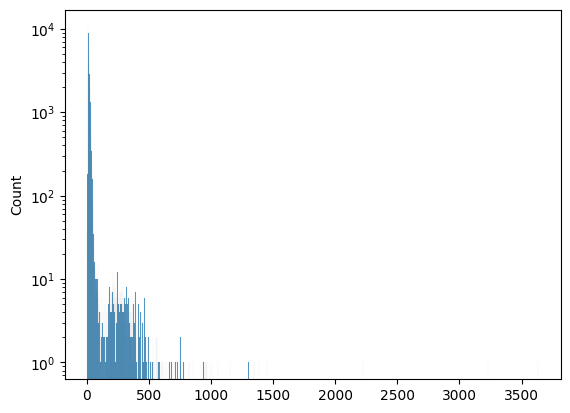

In [9]:
sns.histplot(vols, bins=2000)
plt.yscale("log")

In [10]:
df_low_v = df.loc[vols <= 100, :]
df_large_v = df.loc[vols > 100, :]
df_very_large_v = df.loc[vols > 1000, :]

In [11]:
print(len(df_low_v), len(df_large_v), len(df_very_large_v))

64189 859 11


/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

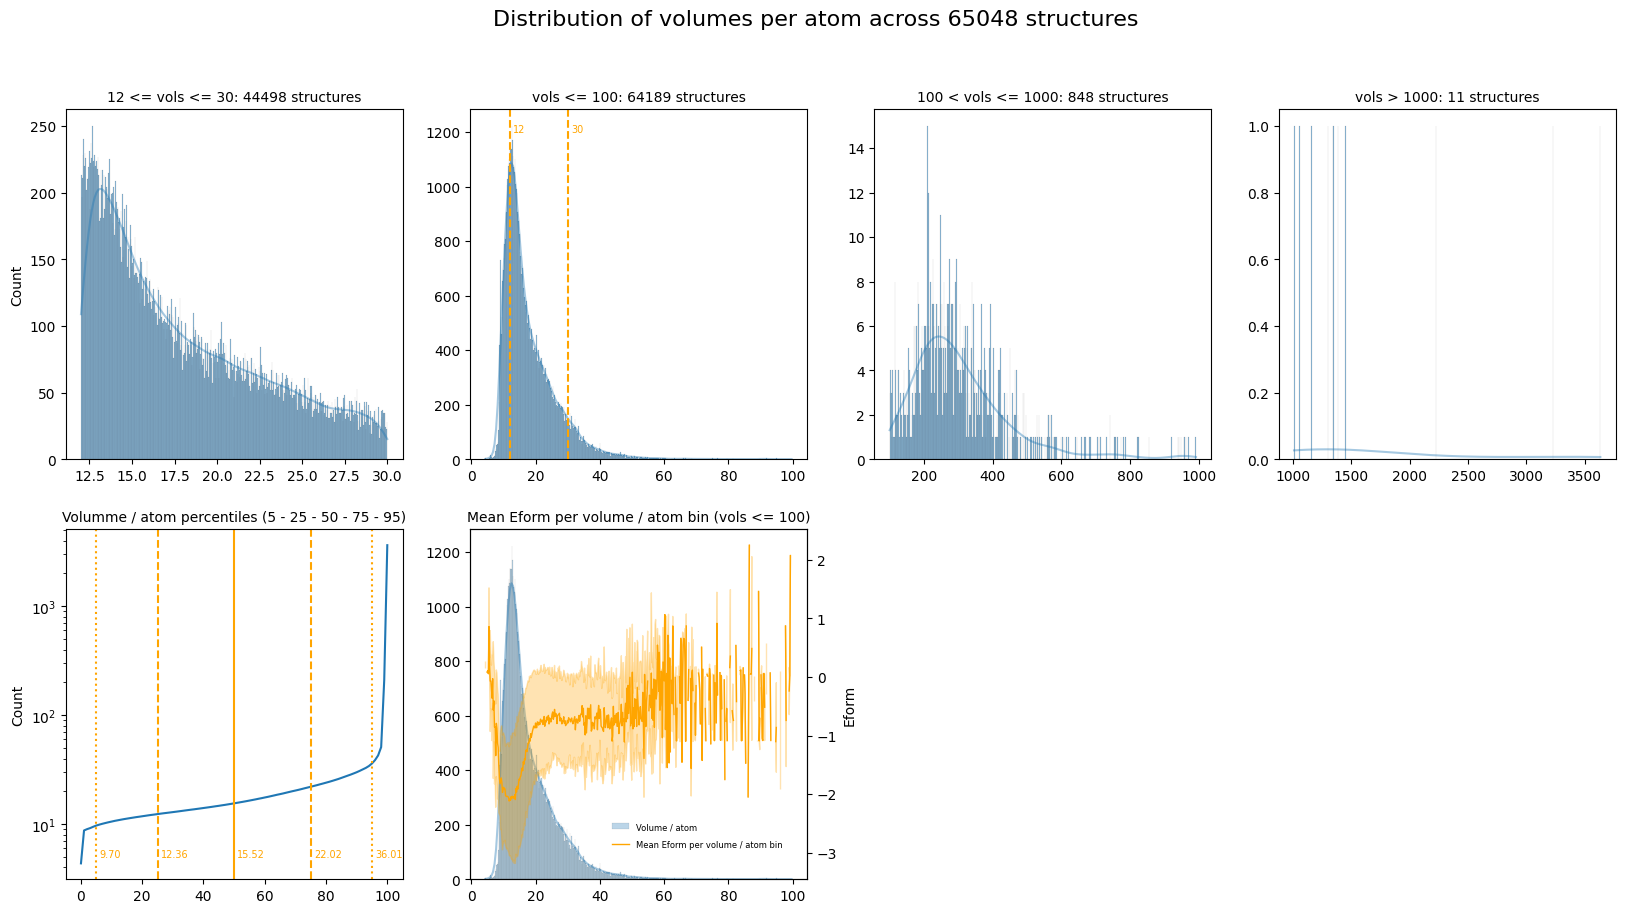

In [44]:
names = ["12 <= vols <= 30", "vols <= 100", "100 < vols <= 1000", "vols > 1000"]
masks = [
    (vols >= 12) & (vols <= 30),
    vols <= 100,
    (vols > 100) & (vols <= 1000),
    vols > 1000,
]
n_bins = 500
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for ax, mask, name in zip(axes[0], masks, names):
    sns.histplot(vols.loc[mask], bins=n_bins, ax=ax, kde=True, line_kws={"alpha": 0.4})
    title = f"{name}: {mask.sum()} structures"
    ax.set_title(title, fontsize=10)
    if ax is not axes[0][0]:
        ax.set_ylabel("")
    if ax is axes[0][1]:
        ax.axvline(12, color="orange", linestyle="--")
        ax.axvline(30, color="orange", linestyle="--")
        ax.text(12 + 1, 1200, "12", color="orange", fontsize=7)
        ax.text(30 + 1, 1200, "30", color="orange", fontsize=7)
percents = np.percentile(vols, range(0, 101))
axes[1][0].plot(range(0, 101), percents)
axes[1][0].set_title("Volumme / atom percentiles (5 - 25 - 50 - 75 - 95)", fontsize=10)
axes[1][0].set_yscale("log")
axes[1][0].set_ylabel("Count")
axes[1][0].axvline(5, color="orange", linestyle="dotted")
axes[1][0].axvline(25, color="orange", linestyle="--")
axes[1][0].axvline(50, color="orange")
axes[1][0].axvline(75, color="orange", linestyle="--")
axes[1][0].axvline(95, color="orange", linestyle="dotted")
axes[1][0].text(5 + 1, 5, f"{percents[5]:.2f}", color="orange", fontsize=7)
axes[1][0].text(25 + 1, 5, f"{percents[25]:.2f}", color="orange", fontsize=7)
axes[1][0].text(50 + 1, 5, f"{percents[50]:.2f}", color="orange", fontsize=7)
axes[1][0].text(75 + 1, 5, f"{percents[75]:.2f}", color="orange", fontsize=7)
axes[1][0].text(95 + 1, 5, f"{percents[95]:.2f}", color="orange", fontsize=7)

condition = 1
eforms = df["Eform"].values[masks[condition]]
values, bins = np.histogram(vols[masks[condition]], bins=n_bins)
binned_eforms = [
    eforms[(vols[masks[condition]] >= bins[i]) & (vols[masks[condition]] < bins[i + 1])]
    for i in range(len(bins) - 1)
]
eforms_means = [np.mean(eform) for eform in binned_eforms]
eforms_stds = [np.std(eform) for eform in binned_eforms]
axx = axes[1][1].twinx()
axx.set_ylabel("Eform")
sns.histplot(
    vols.loc[masks[condition]],
    bins=n_bins,
    ax=axes[1][1],
    kde=True,
    alpha=0.3,
    label="Volume / atom",
    line_kws={"alpha": 0.4},
)
axx.plot(
    bins[:-1],
    eforms_means,
    lw=1,
    color="orange",
    label="Mean Eform per volume / atom bin",
)
axx.fill_between(
    bins[:-1],
    np.array(eforms_means) - np.array(eforms_stds),
    np.array(eforms_means) + np.array(eforms_stds),
    alpha=0.3,
    color="orange",
)
axes[1][1].set_title(
    f"Mean Eform per volume / atom bin ({names[condition]})", fontsize=10
)
axes[1][1].set_ylabel("")
axx.legend(loc="center left", fontsize=6, bbox_to_anchor=(0.4, 0.1), frameon=False)
axes[1][1].legend(
    loc="center left", fontsize=6, bbox_to_anchor=(0.4, 0.15), frameon=False
)

fig.delaxes(axes[1][2])
fig.delaxes(axes[1][3])
title = f"Distribution of volumes per atom across {len(df)} structures"
fig.suptitle(title, fontsize=16)
figpath = Path().cwd() / "plots/volumes/distributions.pdf"
figpath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figpath)

In [19]:
df.columns

Index(['Unnamed: 0', 'Space Group', 'a', 'b', 'c', 'alpha', 'beta', 'gamma',
       'H', 'He',
       ...
       'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Eform', 'cif'],
      dtype='object', length=104)

In [13]:
large_structs = df_large_v.parallel_apply(lambda row: Structure.from_str(row.cif, fmt="cif"), axis=1)

/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/pymatgen/io/cif.py:1148: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/mila/s/sch

In [20]:
st = large_structs.iloc[0]
sga = SpacegroupAnalyzer(st)
ps = sga.get_primitive_standard_structure()
for s in [st, ps]:
    print(s.lattice.volume)
    print(s.lattice.abc)
    print(s.lattice.angles)
    print(len(s))
    print(s.lattice.volume / len(s))
    print()

3687.630338679522
(15.04692208, 15.04692208, 16.28741024)
(90.0, 90.0, 90.0)
32
115.23844808373507

1843.8151693397606
(13.398688932963177, 13.398688932963177, 13.398688932963177)
(111.67980266112296, 111.67980266112296, 105.13899785914397)
16
115.23844808373504



In [14]:
large = df.loc[vols > 1000].sample().iloc[0]
small = df.loc[vols <= 5].sample().iloc[0]

In [15]:
ls = Structure.from_str(large.cif, fmt="cif")
ss = Structure.from_str(small.cif, fmt="cif")

In [11]:
ls

Structure Summary
Lattice
    abc : 11.0140027 14.70050983 42.84230179
 angles : 90.0 90.0 90.0
 volume : 6936.659416611323
      A : 11.0140027 0.0 6.744131576177654e-16
      B : 2.3640222819417043e-15 14.70050983 9.00146615457185e-16
      C : 0.0 0.0 42.84230179
    pbc : True True True
PeriodicSite: Dy (5.5070, 7.3503, 4.8860) [0.5000, 0.5000, 0.1140]
PeriodicSite: Dy (5.5070, 7.3503, 37.9563) [0.5000, 0.5000, 0.8860]
PeriodicSite: Se (5.5070, 7.3503, 28.7223) [0.5000, 0.5000, 0.6704]
PeriodicSite: Se (5.5070, 7.3503, 14.1200) [0.5000, 0.5000, 0.3296]
PeriodicSite: I (5.5070, 7.3503, 2.1219) [0.5000, 0.5000, 0.0495]
PeriodicSite: I (5.5070, 7.3503, 40.7204) [0.5000, 0.5000, 0.9505]

In [16]:
ss

Structure Summary
Lattice
    abc : 2.89684773 3.68771229 4.17890423
 angles : 90.0 102.29131875000002 90.0
 volume : 43.61885695143544
      A : 2.8304457252020483 0.0 -0.6166877390475722
      B : 5.930293659039897e-16 3.68771229 2.2580725260624277e-16
      C : 0.0 0.0 4.17890423
    pbc : True True True
PeriodicSite: Fe (1.4240, 0.9219, 0.6746) [0.5031, 0.2500, 0.2357]
PeriodicSite: Fe (1.4065, 2.7658, 2.8877) [0.4969, 0.7500, 0.7643]
PeriodicSite: H (0.5841, 1.8492, 1.6748) [0.2064, 0.5014, 0.4312]
PeriodicSite: H (2.2463, 0.0053, 1.8874) [0.7936, 0.0014, 0.5688]
PeriodicSite: H (2.2463, 1.8385, 1.8874) [0.7936, 0.4986, 0.5688]
PeriodicSite: H (0.5841, 3.6824, 1.6748) [0.2064, 0.9986, 0.4312]
PeriodicSite: H (1.5478, 2.7658, 0.2903) [0.5469, 0.7500, 0.1502]
PeriodicSite: H (1.2826, 0.9219, 3.2720) [0.4531, 0.2500, 0.8498]
PeriodicSite: H (0.0000, 1.8439, 0.0000) [0.0000, 0.5000, 0.0000]
PeriodicSite: H (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]